*NAME:R.MOHANA SHRI
ROL NO:241801167*

Loading breast cancer dataset...
Dataset shape: (569, 30)
Classes: [0 1]
Training set: (455, 30), Test set: (114, 30)
Train class distribution: [170 285]
Test class distribution: [42 72]

Gradient Boosting Parameters:
  n_estimators: 50
  learning_rate: 0.1
  max_depth: 3
  Estimator 10/50 - Training MSE: 0.049029
  Estimator 20/50 - Training MSE: 0.014353
  Estimator 30/50 - Training MSE: 0.007540
  Estimator 40/50 - Training MSE: 0.004599
  Estimator 50/50 - Training MSE: 0.003069
Training complete!
Unique predicted values: [0 1]

EVALUATION METRICS
Accuracy:  0.9386
Precision: 0.9452
Recall:    0.9583
F1-Score:  0.9517
ROC AUC:   0.9907

Confusion Matrix:
[[38  4]
 [ 3 69]]
TN: 38, FP: 4, FN: 3, TP: 69

Classification Report:
              precision    recall  f1-score   support

   malignant       0.93      0.90      0.92        42
      benign       0.95      0.96      0.95        72

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93

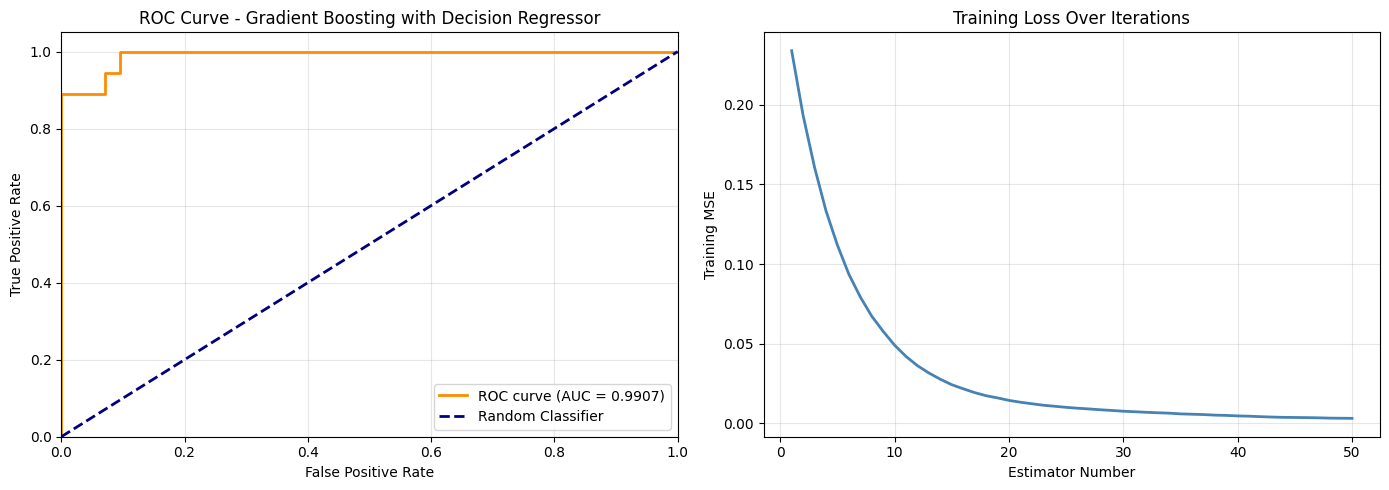


Program completed successfully!


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve, auc)



# 2. Load data
print("Loading breast cancer dataset...")
data = load_breast_cancer()
X = data.data
y = data.target
print(f"Dataset shape: {X.shape}")
print(f"Classes: {np.unique(y)}")

# 3. Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Train class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

# 4. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Initialize predictions with mean
initial_pred_train = np.full_like(y_train, y_train.mean(), dtype=float)
initial_pred_test = np.full_like(y_test, y_train.mean(), dtype=float)

# 6. Define Gradient Boosting parameters
n_estimators = 50
learning_rate = 0.1
max_depth = 3
random_state = 42

print(f"\nGradient Boosting Parameters:")
print(f"  n_estimators: {n_estimators}")
print(f"  learning_rate: {learning_rate}")
print(f"  max_depth: {max_depth}")

# 7. Train Gradient Boosting
predictions_train = initial_pred_train.copy()
predictions_test = initial_pred_test.copy()
estimators = []
train_losses = []

for i in range(n_estimators):
    # Compute residuals
    residuals_train = y_train - predictions_train
    
    # Fit weak learner (Decision Tree Regressor) on residuals
    regressor = DecisionTreeRegressor(
        max_depth=max_depth, 
        random_state=random_state + i
    )
    regressor.fit(X_train_scaled, residuals_train)
    
    # Get predictions from the weak learner
    pred_residuals_train = regressor.predict(X_train_scaled)
    pred_residuals_test = regressor.predict(X_test_scaled)
    
    # Update predictions with learning rate
    predictions_train += learning_rate * pred_residuals_train
    predictions_test += learning_rate * pred_residuals_test
    
    # Store estimator and compute loss
    estimators.append(regressor)
    train_loss = np.mean(residuals_train ** 2)
    train_losses.append(train_loss)
    
    # Print training progress
    if (i + 1) % 10 == 0:
        print(f"  Estimator {i+1}/{n_estimators} - Training MSE: {train_loss:.6f}")

print("Training complete!")

# 8. Convert predictions to binary class (0/1) using 0.5 threshold
y_pred_proba = predictions_test  # Continuous predictions
y_pred = (y_pred_proba >= 0.5).astype(int)  # Threshold at 0.5
print(f"Unique predicted values: {np.unique(y_pred)}")

# 9. Evaluate on test set
print("\n" + "="*50)
print("EVALUATION METRICS")
print("="*50)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"TN: {cm[0,0]}, FP: {cm[0,1]}, FN: {cm[1,0]}, TP: {cm[1,1]}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=data.target_names))

# 10. Plot ROC curve
print("\nGenerating ROC curve...")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_plot = auc(fpr, tpr)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_plot:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - Gradient Boosting with Decision Regressor')
axes[0].legend(loc="lower right")
axes[0].grid(alpha=0.3)

# Training Loss Curve
axes[1].plot(range(1, n_estimators + 1), train_losses, color='steelblue', lw=2)
axes[1].set_xlabel('Estimator Number')
axes[1].set_ylabel('Training MSE')
axes[1].set_title('Training Loss Over Iterations')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nProgram completed successfully!")